In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [52]:
item_features = pd.read_csv('item-features.csv')
user_features = pd.read_csv('user_features.csv')
data_train = pd.read_csv('train (3).csv')
data_test = pd.read_csv('test (3).csv')

## EDA

Item and user features are vectors from $\mathbb{R}^{32}$, but as we'll see later they are not practically important. Items have several linear dependent features which we should clear from our data. Also, almost all features contain outliers (see the histrogram below). 

User features are even more unpromising - all of them are linearly dependent, thus we have only 1-2 reliable features. Not that much for clustering.

In [53]:
# firstly, let's check whether do we have the same user-IDs in test and train data

ID_counter = 0
for ID in data_test['user_id']:
    if ID in data_train['user_id']:
        ID_counter += 1
ID_counter == data_test.shape[0] # yes, they're the same

True

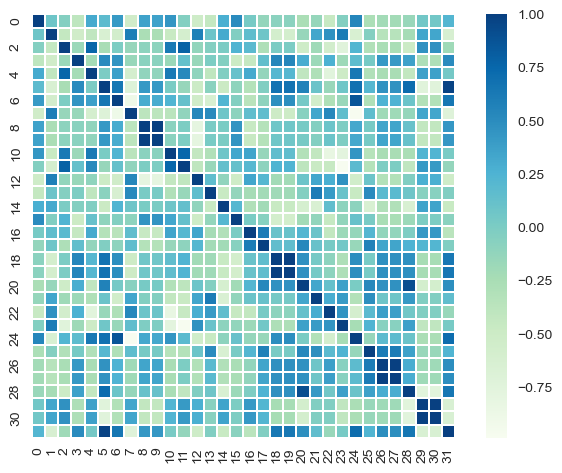

In [54]:
# plotting correlation matrix for user features

item_features = pd.read_csv('item-features.csv')
sns.heatmap(item_features[user_features.columns[1:]].corr(), 
            annot = False, fmt='.2f', linewidth=0.01, \
            square=True, cmap='GnBu'); 
plt.savefig('correlation_item_features.png', dpi = 300)

In [55]:
item_features[['8', '9', '10', '29', '30', '18','19']].corr() # (8, 9) (29,30), (18,19) - identical features

,8,9,10,29,30,18,19
8,1.000000,1.000000,-0.076478,-0.420319,-0.420319,0.068029,0.068029
9,1.000000,1.000000,-0.076478,-0.420319,-0.420319,0.068029,0.068029
10,-0.076478,-0.076478,1.000000,0.238782,0.238782,0.148552,0.148552
29,-0.420319,-0.420319,0.238782,1.000000,1.000000,-0.241576,-0.241576
30,-0.420319,-0.420319,0.238782,1.000000,1.000000,-0.241576,-0.241576
18,0.068029,0.068029,0.148552,-0.241576,-0.241576,1.000000,1.000000
19,0.068029,0.068029,0.148552,-0.241576,-0.241576,1.000000,1.000000


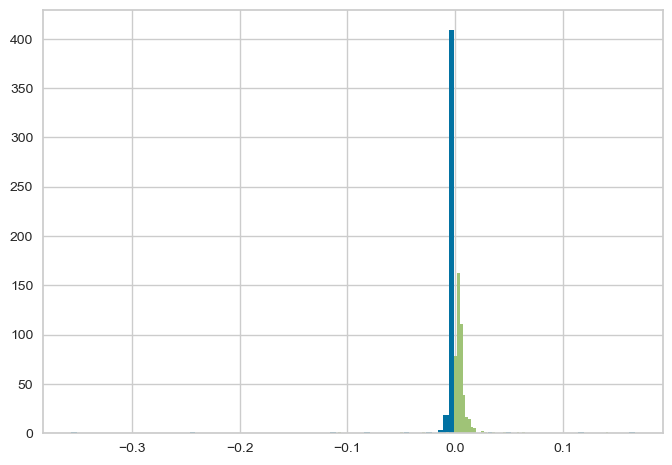

In [56]:
# all features have outliers  

item_id = item_features['item_id']
item_features = item_features.drop(['item_id', '9', '30','19'], axis = 1)
np.log1p(item_features['1']).hist(bins = 100)
np.log1p(item_features['10']).hist(bins = 100);

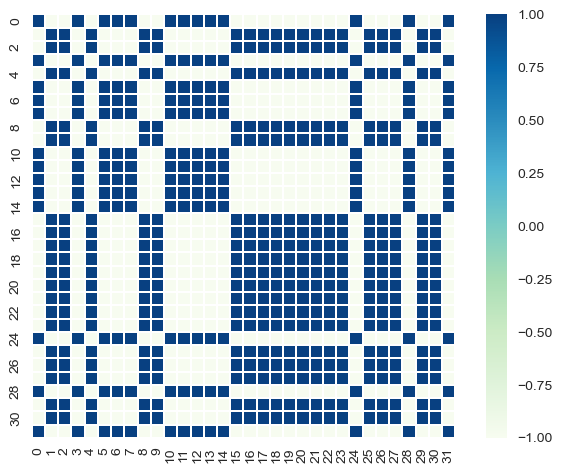

In [57]:
# correlation matrix for user features: all lineary dependent

sns.heatmap(user_features[user_features.columns[1:]].corr(), 
            annot = False, fmt='.2f', linewidth=0.01, \
            square=True, cmap='GnBu'); # no chance to cluster
plt.savefig('correlation_user_features.png', dpi = 300)

## Clustering idea (did not work)

Suppose we can assign each item for a particular cluster (spoiler: we can not), then we can *display posts from the most liked cluster for each user which he does not seen*.

To define how many clusters should it be, we tried [Silhouette coefficient](https://en.wikipedia.org/wiki/Silhouette_(clustering)) but it gave us minimal number of clusters - not promising result, so we tried [elbow coefficient approach](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) for utterly different algorithms: hierarchical clustering (AgglomerativeClustering) and metric (KMeans). All gave $k=7$ as efficient number of clusters, but... 

Both methods gave a little clusters with essential number of items, therefore clusteting idea would be inefficient. 

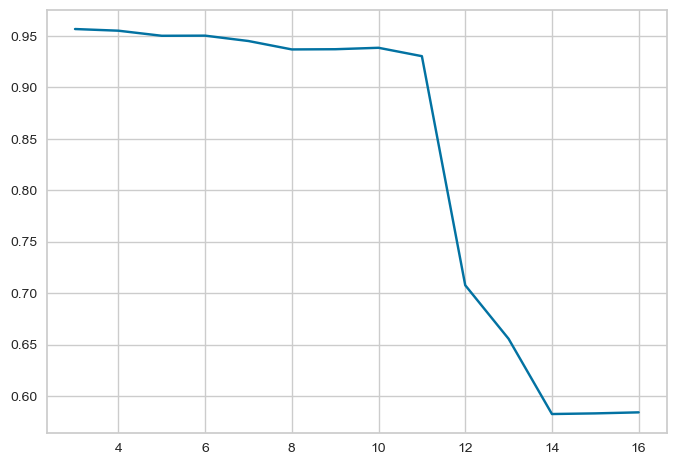

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler

k_list = list(range(3, 17))
scores = []

item_features = MinMaxScaler().fit_transform(item_features)

for k in k_list:
    clustering = KMeans(n_clusters = k).fit(item_features) 
    predicted_labels = clustering.predict(item_features)
    scores.append(silhouette_score(item_features, predicted_labels))
    
plt.plot(k_list, scores); # k = 3 is an optimal number of clusters

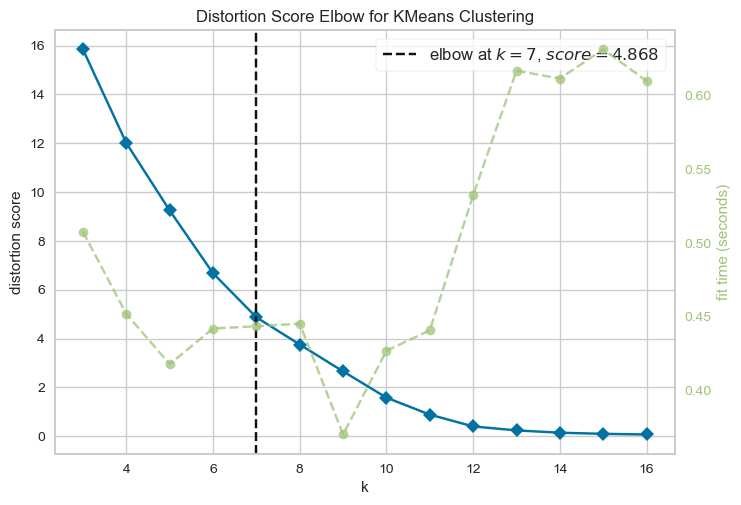

In [59]:
# а здесь k = 7
vis = KElbowVisualizer(KMeans(), k = k_list).fit(item_features)
vis.show(outpath="Clustering_features_score.png", dpi = 300);

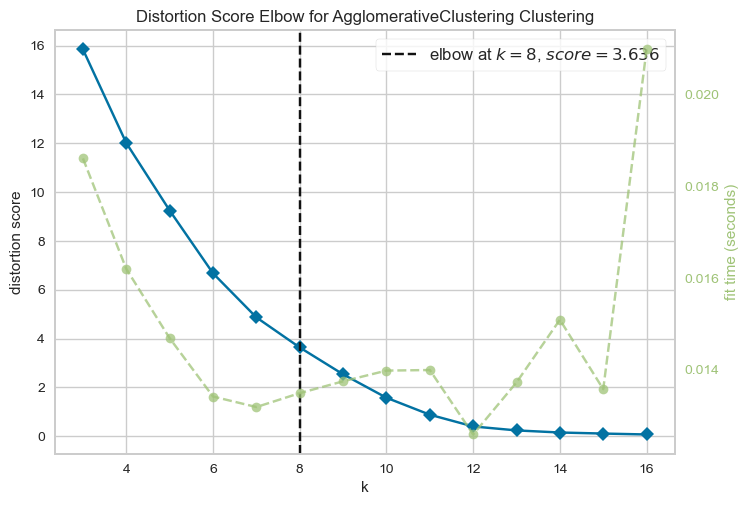

In [60]:
from sklearn.cluster import AgglomerativeClustering

vis = KElbowVisualizer(AgglomerativeClustering(), k = k_list).fit(item_features)
vis.show(outpath="Clustering_features_score_agglomerative.png", dpi = 300);

In [61]:
clustering_kmeans = KMeans(n_clusters=8)
clusters_kmeans = pd.Series(clustering.fit_predict(item_features))

clustering_aggl = AgglomerativeClustering(n_clusters = 8)
clusters_aggl = pd.Series(clustering.fit_predict(item_features))

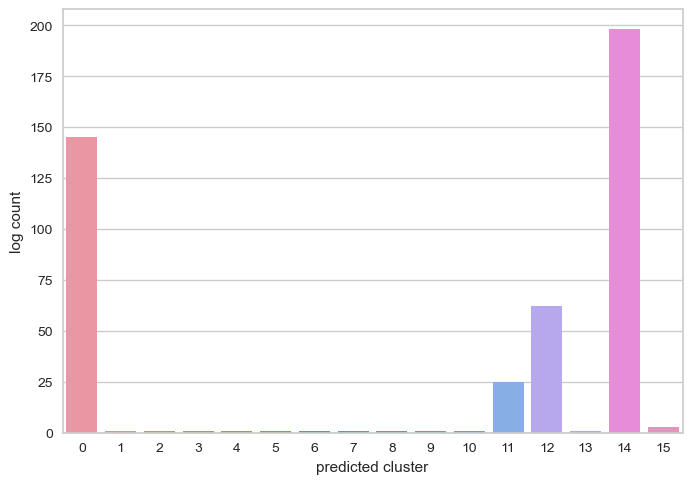

In [62]:
fig, ax = plt.subplots()
sns.barplot(x = clusters_kmeans.value_counts().index, y = clusters_kmeans.value_counts(), ax = ax)
ax.set(xlabel = 'predicted cluster', ylabel = 'log count');
plt.savefig('predicted_clusters.png', dpi = 300)

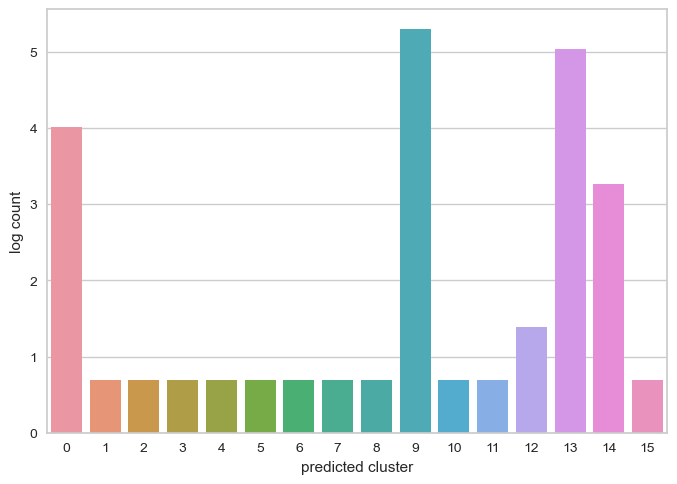

In [63]:
fig, ax = plt.subplots()

sns.barplot(x = clusters_aggl.value_counts().index, y = np.log1p(clusters_aggl.value_counts()), ax = ax)
ax.set(xlabel = 'predicted cluster', ylabel = 'log count');
plt.savefig('predicted_clusters_agglomerative.png', dpi = 300)

## Item-based approach (gave the best 0.535 accuracy)

Item-based approach is driven by the idea that *user tends to like posts which are similar to those he already liked*. Then, we should calculate similarities between items from user-item matrix and perform a dot product for the user vector and item similarity vector. 

We used cosine similarity and a similarity metric which is equal to scalar product because previously we normalized item vectors.  

In [64]:
user_item_matrix = data_train.pivot(index = 'user_id', columns = 'item_id', values = 'like')

In [65]:
user_item_matrix = user_item_matrix.fillna(-1) # filling with -1 empirically gives the best result
user_item_matrix.head()

item_id,0,1,2,3,4,5,6,7,8,9,...,434,435,436,437,438,439,440,441,442,443
user_id,,,,,,,,,,,,,,,,,,,,,
0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [66]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# As a first step we normalize the user vectors to unit vectors.

# magnitude = norm of each vector
magnitude = np.sqrt(np.square(user_item_matrix).sum(axis=1))

# normalizing item vectors
user_item_matrix = user_item_matrix.divide(magnitude, axis='index')

def calculate_similarity(user_item_matrix):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(user_item_matrix)
    similarities = cosine_similarity(data_sparse.T) # also tried spearman and kendall correlation - gave worse results
    sim = pd.DataFrame(data=similarities, index = user_item_matrix.columns, columns= user_item_matrix.columns)
    return sim

# Build the similarity matrix
data_matrix = calculate_similarity(user_item_matrix)



In [67]:
user = 0 # The id of the user for whom we want to generate recommendations
user_index = user_item_matrix.iloc[user_item_matrix.index == user].index.tolist()[0] # Get the frame index

def recommend(user_item_matrix, user_index):
    # Get the artists the user has liked.
    known_user_likes = user_item_matrix.iloc[user_index]
    known_user_likes = known_user_likes[known_user_likes >= 0].index.values

    # Users likes for all items as a sparse vector.
    user_rating_vector = user_item_matrix.iloc[user_index]

    # Calculate the score.
    score = data_matrix.dot(user_rating_vector).div(data_matrix.sum(axis=1))
    
    # Remove the known likes from the recommendation.
    score = score.drop(known_user_likes)
    return score.nlargest(20).index

# Just testing number of recommendations
print(len(recommend(user_item_matrix, 3)))

20


In [68]:
recommendations = {}
for index, row in data_test.iterrows():
    user_id = row['user_id']
    recommendations[user_id] = list(recommend(user_item_matrix, user_id))

In [69]:
# finally, making predictions
recs_item = pd.DataFrame(recommendations).T.reset_index().rename({'index': 'user_id'}, axis = 1)
recs_item.to_csv('submission3_10.csv', index = False)
recs_item.head()

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,166,17,155,35,63,137,70,72,95,265,...,80,264,62,36,180,118,46,210,112,385
1,26,258,267,273,213,250,218,125,27,269,...,212,248,264,272,89,215,152,108,209,20
2,41,22,264,46,19,27,43,265,263,84,...,218,360,99,183,18,138,6,20,13,2
3,286,22,265,210,262,27,119,107,19,84,...,146,44,218,78,172,118,229,43,138,58
4,108,76,188,325,114,422,50,82,423,184,...,110,102,200,201,68,133,161,148,424,441


## Classifications (worse, but still 0.45)

Let's suppose we're trying to solve a classification problem for group of features: $(\text{user_id}, \text{item_id}, \text{item_id}, \text{time in nanoseconds}, \text{is time small}, \text{is time large})$. 

The last two features are derived from a timestamp given in logs. If we look closely to each data, we'll easily guess that data is synthetic because logs are given only in the interval of one second in 1970. Nevertheless, some information can be extracted from the timestamp. There are 2 main groups of time: less than $2\cdot10^8$ and greater. In the first group more items are unliked while in the second more are liked.

Having data prepared, let's train a model (CatBoostClassifier), then launch it on every pair $(\text{user_id}, \text{item_id})$ and finally arrange pairs for each user excluding seen items.

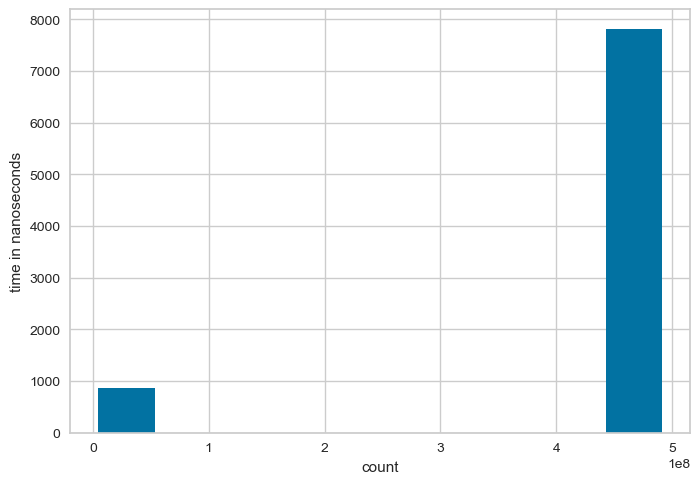

In [70]:
def apply_time(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['time'] = data['timestamp'].apply(lambda x: int(str(x.microsecond) + str(x.nanosecond)))
    
    
    data['time_small'] = data['time'].apply(lambda x: 1 if x <= 2*10**8 else 0)
    data['time_large'] = data['time'].apply(lambda x: 1 if x > 2*10**8 else 0)

apply_time(data_train)
apply_time(data_test)

fig, ax = plt.subplots()
data_train['time'].hist(ax = ax)
ax.set(xlabel = 'count', ylabel = 'time in nanoseconds')
fig.savefig('time_feature_distribution.png', dpi = 300)

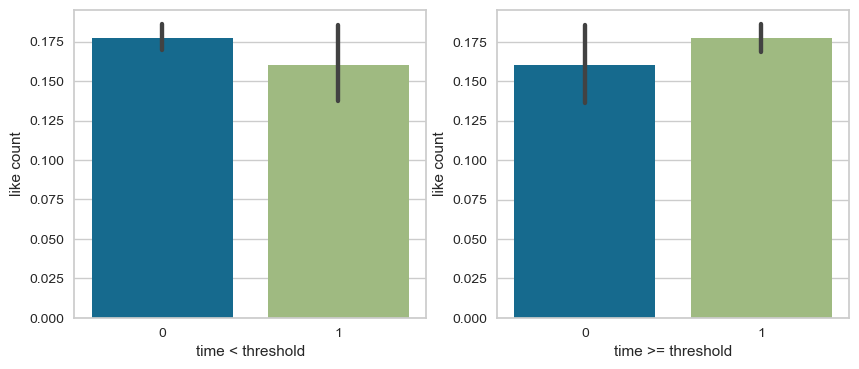

In [88]:
fig, ax = plt.subplots(1,2, figsize = (10,4)) # can be a good feature

sns.barplot(x = data_train['time_small'], y = data_train['like'], ax = ax[0])
sns.barplot(x = data_train['time_large'], y = data_train['like'], ax = ax[1]);
ax[0].set(xlabel = 'time < threshold', ylabel = 'like count')
ax[1].set(xlabel = 'time >= threshold', ylabel = 'like count')

fig.savefig('like propotion according to time.png', dpi = 300)

In [72]:
# training catboost model
from catboost import CatBoostClassifier

X, y = data_train.drop(['timestamp', 'like'], axis =  1), data_train['like']
clf = CatBoostClassifier(silent = True).fit(X,y)

In [73]:
# creating a new test dataset with each pair (user_id, item_id)

item_features = pd.read_csv('item-features.csv')
data_test = data_test.drop('timestamp', axis = 1).set_index('user_id')
item_ids = item_features['item_id']

from tqdm import tqdm
combinations = []

for item_id in tqdm(item_ids):
    for user_id in data_test.index:
        combinations.append((user_id, item_id))
        
new_data_test = pd.DataFrame(combinations).rename({0:'user_id', 1:'item_id'}, axis = 1)
new_data_test = pd.merge(left=new_data_test, right=data_test, on = 'user_id')

100%|██████████████████████████████████████████████████████████████████████████████| 444/444 [00:00<00:00, 2222.73it/s]


In [74]:
new_data_test['prob'] = clf.predict_proba(new_data_test)[:, 1]
new_data_test.head()

,user_id,item_id,time,time_small,time_large,prob
0,166,35,490944431,0,1,0.950246
1,166,19,490944431,0,1,0.727742
2,166,145,490944431,0,1,0.734547
3,166,36,490944431,0,1,0.764548
4,166,357,490944431,0,1,0.000085


In [75]:
def predict_postes(user_id, data_train, data_test):
    '''
    Predicting postes for each user_id in data_test
    '''
    evaluated_ids = data_train['item_id'][data_train['user_id'] == user_id]
    items = data_test[data_test['user_id'] == user_id].sort_values(by = 'prob', ascending = False)['item_id'].to_numpy()
    
    predicted_posts = []
    i = 0
    while len(predicted_posts) < 20:
        if (items[i] not in evaluated_ids) and (items[i] not in predicted_posts):
            predicted_posts.append(items[i])
        i+=1
    return predicted_posts 

In [76]:
user_ids = data_test.index
predictions = {}
for user_id in user_ids:
    predictions[user_id] = predict_postes(user_id, data_train, new_data_test)
    
recs_cat = pd.DataFrame(predictions).T.reset_index().rename({'index':'user_id'}, axis = 1)
recs_cat.to_csv('submission3_11.csv', index = False)
recs_cat.head()

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,166,22,76,35,37,72,40,66,61,60,...,73,75,74,65,64,77,59,21,36,58
1,26,22,37,35,7,8,76,6,40,5,...,72,61,60,80,74,73,75,77,11,4
2,41,22,76,37,35,40,8,7,6,5,...,61,60,80,21,75,73,74,77,19,38
3,286,22,76,35,72,37,80,66,61,60,...,64,73,75,74,77,36,40,147,58,59
4,108,22,76,37,35,40,72,60,61,80,...,74,75,73,58,19,21,66,59,38,39


## User-based approach (a.k.a collaborative filtering) (did not work)

It is a analogous to item-based approach: we should recommend user posts which other users (similar to a given one) liked. So, we also calculate cousine similarity and perform a dot product for similarity vector and user vector.  

In [77]:
user_item_matrix = data_train.pivot(index = 'user_id', columns = 'item_id', values = 'like')

In [78]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# filling Nan with -1 gave the best result (however, it did not mathematically justified)
user_item_matrix_filled = user_item_matrix.fillna(-1)

similarity_matrix = cosine_similarity(user_item_matrix_filled)

similarity_matrix_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

def recommend_items(user_id, matrix, similarity_matrix, top_n=20):
    if user_id not in matrix.index:
        raise ValueError("User ID not found in the matrix")

    user_ratings = matrix.iloc[user_id]

    user_similarity = similarity_matrix[user_id]

    weighted_ratings = np.dot(user_similarity, matrix)

    # Normalizing final ratings
    sum_similarities = np.array([np.abs(user_similarity).sum() for _ in range(len(weighted_ratings))])
    normalized_ratings = weighted_ratings / sum_similarities

    # exclude evaluated features
    normalized_ratings[user_ratings >= 0] = 0

    # get recommendations
    recommendation_ids = np.argsort(-normalized_ratings)[:top_n]

    return matrix.columns[recommendation_ids]

recommendations = recommend_items(user_id=123, matrix=user_item_matrix_filled, similarity_matrix=similarity_matrix_df)
len(recommendations)

20

In [79]:
from tqdm import tqdm
recommendations = {} 

# performs long time, be carefull with running a cell
for user_id in tqdm(data_test.index.values):
    recommendations[user_id] = recommend_items(user_id=user_id, 
                                               matrix=user_item_matrix_filled, 
                                               similarity_matrix=similarity_matrix_df)
recs = pd.DataFrame(recommendations).T.reset_index().rename({'index': 'user_id'}, axis = 1)
recs.to_csv('submission3_13.csv', index = False)
recs.head()

100%|████████████████████████████████████████████████████████████████████████████████| 497/497 [01:19<00:00,  6.23it/s]


,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,166,173,217,67,177,153,168,421,426,253,...,115,257,318,262,429,394,76,22,35,100
1,26,322,251,270,54,268,211,271,252,242,...,86,216,249,157,1,246,76,22,35,100
2,41,221,42,16,109,276,275,274,266,121,...,139,260,230,229,153,261,76,22,35,100
3,286,221,86,360,266,121,264,46,42,263,...,260,139,230,153,16,40,76,22,35,100
4,108,92,100,65,390,129,143,404,9,405,...,402,403,165,194,178,154,76,22,35,72


## Pure SVD  (0.517)

It's a common technique which uses SVD of user-item matrix. Still there are two factors to be discussed.

Filling missing values with $-2$ now performs better than $-1$. Again, there is no mathematical foundation behind that but emperically it works better.

Rank of a decomposition is the other hyperparameter to configure. $r = 20$ shows best result on the test data. 

In [80]:
from numpy.linalg import svd

user_item_matrix = data_train.pivot(index = 'user_id', columns = 'item_id', values = 'like')
user_item_matrix = user_item_matrix.fillna(-2)

U, S, VT = svd(user_item_matrix, full_matrices=False)
S_rank = np.concatenate((S[0:20], np.zeros(S.shape[0]-20)))
reconstructed_user_item = pd.DataFrame(U @ np.diag(S_rank) @ VT, index = user_item_matrix.index) 

In [81]:
def svd_recommend(user_id, reconstructed_matrix, matrix):
    evaluated_items = matrix.iloc[user_id][matrix.iloc[user_id] >= 0].index
    potential_items = reconstructed_matrix.iloc[user_id].drop(evaluated_items).sort_values(ascending = False)
    potential_items = potential_items[:20].index.values
    
    return potential_items

svd_recommend(166, reconstructed_user_item, user_item_matrix)
    

array([ 72, 265,  17, 264,  35, 365,  80,  46,  57, 428,  42, 427, 155,
       137, 208, 230, 180,  63,  70,  43], dtype=int64)

In [82]:
from tqdm import tqdm
data_test = pd.read_csv('test (3).csv')
recommendations = {} 

for user_id in tqdm(data_test['user_id']):
    recommendations[user_id] = svd_recommend(user_id=user_id, 
                                               reconstructed_matrix=reconstructed_user_item, 
                                               matrix=user_item_matrix)
recs_svd = pd.DataFrame(recommendations).T.reset_index().rename({'index': 'user_id'}, axis = 1)
recs_svd.to_csv('submission3_14.csv', index = False)
recs_svd.head()

100%|███████████████████████████████████████████████████████████████████████████████| 497/497 [00:01<00:00, 298.23it/s]


,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,166,72,265,17,264,35,365,80,46,57,...,42,427,155,137,208,230,180,63,70,43
1,26,258,267,273,250,248,218,269,152,219,...,247,125,209,272,212,213,231,168,140,0
2,41,264,22,46,265,76,263,18,60,72,...,218,433,86,253,43,30,262,360,257,296
3,286,22,265,262,229,7,275,218,60,146,...,210,433,253,257,19,27,394,251,242,429
4,108,76,188,22,80,58,66,72,60,88,...,11,208,365,184,147,427,146,428,142,162


## Model ensambles (0.42 - strange)

Ensambles can decrease variance with no effect (or even increasing) bias component. So, let's try our few successful models: item-based approach, svd and classification with catboost. We tried 2 main methods of voting:

- *A simple one*. As item-based approach is better than others, we surely prefer it's predictions to others. But if 2 remaining alogoritms give a different prediction for a particular place in their item preferences, we replace their first model's prediction with their. Otherwise, we use only an item-based prediction.
- *More complicated*. It is a rule from a voting theory which ranks all item predictios with score according to weight of a model (in our case 1 - item_based, 3/5 - svd, 4/5, catboost) and index of prediction (because they are sorted in not increasing order bigger index means less confidence of a model).

In [83]:
def give_recommendations(user_id, recs_item, recs_cat, recs_svd):
    
    user_recs_item = recs_item.set_index('user_id').iloc[user_id].to_numpy()
    user_recs_cat = recs_cat.set_index('user_id').iloc[user_id].to_numpy()
    user_recs_svd = recs_svd.set_index('user_id').iloc[user_id].to_numpy()
    
    new_recommendations = []
    for i in range(20):
        if user_recs_cat[i] == user_recs_svd[i]:
            new_recommendations.append(user_recs_cat[i])
        else: new_recommendations.append(user_recs_item[i])
            
    return new_recommendations

def give_recommendations_advanced(user_id, recs_item, recs_cat, recs_svd):
    
    user_recs_item = recs_item.set_index('user_id').iloc[user_id].to_numpy()
    user_recs_cat = recs_cat.set_index('user_id').iloc[user_id].to_numpy()
    user_recs_svd = recs_svd.set_index('user_id').iloc[user_id].to_numpy()
    
    items_ratings = {}
    for i in range(len(user_recs_item)):
        # each elements is given a weight = 1/index of an element
        items_ratings[user_recs_item[i]] = 1/(i+1)
    for j in range(len(user_recs_cat)):
        if user_recs_cat[j] not in items_ratings.keys():
            # addina a similar weight but multiplied by wieght of the second model
            items_ratings[user_recs_cat[j]] = 3/5*(1 / (j+1))
        else:
            items_ratings[user_recs_cat[j]] += 3/5*(1 / (j+1))
    
    for j in range(len(user_recs_svd)):
        if user_recs_cat[j] not in items_ratings.keys():
            items_ratings[user_recs_cat[j]] = 4/5 * (1 / (j+1))
        else:
            items_ratings[user_recs_cat[j]] += 4/5 *(1 / (j+1))
    
    sorted_items = sorted(items_ratings.items(), key = lambda x: x[1], reverse = True)[:20]
    recommendations = list(map(lambda x: x[0], sorted_items))
    
    return recommendations

In [84]:
# simple model (decreased result)

from tqdm import tqdm
recommendations = {} 

for user_id in tqdm(data_test['user_id']):
    recommendations[user_id] = give_recommendations(user_id=user_id, 
                                               recs_item = recs_item, 
                                               recs_cat=recs_cat, 
                                               recs_svd = recs_svd)
recs_new = pd.DataFrame(recommendations).T.reset_index().rename({'index': 'user_id'}, axis = 1)
recs_new.to_csv('submission3_15.csv', index = False)
recs_new.head()

100%|███████████████████████████████████████████████████████████████████████████████| 497/497 [00:01<00:00, 282.75it/s]


,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,166,80,58,118,40,35,32,155,17,67,...,66,66,72,88,63,107,11,146,147,21
1,26,44,40,138,119,172,159,71,78,107,...,124,80,62,17,11,63,67,196,146,123
2,41,268,271,267,270,273,248,211,152,269,...,167,247,219,213,155,140,272,67,17,137
3,286,22,39,58,44,30,21,138,132,63,...,96,2,33,108,90,40,262,99,137,17
4,108,67,40,80,155,72,22,118,32,58,...,36,44,30,137,112,33,41,66,138,37


In [85]:
# complicated voting rule (also slightly decreased results)

from tqdm import tqdm
recommendations = {} 

for user_id in tqdm(data_test['user_id']):
    recommendations[user_id] = give_recommendations_advanced(user_id=user_id, 
                                               recs_item = recs_item, 
                                               recs_cat=recs_cat, 
                                               recs_svd = recs_svd)
recs_new_advanced = pd.DataFrame(recommendations).T.reset_index().rename({'index': 'user_id'}, axis = 1)
recs_new_advanced.to_csv('submission3_16.csv', index = False)
recs_new_advanced.head()

100%|███████████████████████████████████████████████████████████████████████████████| 497/497 [00:01<00:00, 292.09it/s]


,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,166,22,80,35,58,37,40,72,76,118,...,66,32,11,61,155,60,21,17,67,70
1,26,22,44,76,40,35,72,138,80,37,...,172,66,60,159,61,71,65,64,78,77
2,41,22,268,76,271,37,35,267,40,270,...,273,61,72,248,80,211,77,58,152,19
3,286,22,40,76,39,58,35,37,44,61,...,30,60,72,21,66,138,64,65,132,63
4,108,22,67,76,40,72,37,80,60,65,...,155,61,58,36,118,64,33,32,59,75


## Further exploration

As a future work, one can explore various approaches, such as:
1. SVD with item features (can be helpful)
2. [ALS](https://sophwats.github.io/2018-04-05-gentle-als.html) with no attention to missing values
3. Different voting rules 
4. Neural networks with emdeddings. 